Needs scikilt-learn 0.22

```
pip uninstall scikit-learn
pip install scikit-learn==0.22
```

In [1]:
import ast
import os
import pickle
import re
from collections import OrderedDict
from configparser import ConfigParser
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from scipy.special import iv, logsumexp
from sklearn.neighbors import NearestNeighbors
from tqdm.notebook import tqdm

import sys
sys.path.append('../')
sys.path.append('../src')
from src.snapconfig import config
config.PARAM_PATH = '../config.ini'
import run_train as main
from src.snaptrain import dataset, trainmodel
from src.snaputils import simulatespectra as sim

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

In [3]:
# Load the data
df_all = pd.read_csv('outputs/df_all.csv')

In [7]:
# count true entries in the snap_label column
print('True entries in snap_label column: ', df_all.snap_label.value_counts())

True entries in snap_label column:  True     2649
False     411
Name: snap_label, dtype: int64


In [4]:
# Preprocess the data
df_all.drop('id', axis=1, inplace=True)
df_all = pd.get_dummies(df_all, columns=['spec_charge'])
df_all['snap_label'] = df_all['snap_label'].map({True: 1, False: 0})

In [5]:
# Define the feature columns
feature_cols = [col for col in df_all.columns if col not in ['snap_1', 'snap_2', 'snap_label', 'spec_mass']]

# Define the label columns
label_cols = ['snap_1', 'snap_2', 'snap_label']

In [6]:
# Separate the features and labels
X = df_all[feature_cols]
y = df_all[label_cols]

In [7]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# Apply SMOTE for 'snap_label'
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y['snap_label'])

# Join the resampled 'snap_label' with 'snap_1' and 'snap_2'
# y_res = pd.concat([y_res, y['snap_1'], y['snap_2']], axis=1)

In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [10]:
np.isnan(y_train).sum()

0

In [11]:
# Define the model
model = RandomForestRegressor(random_state=42)

In [12]:
# Define the grid of hyperparameters 'param_grid'
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [29]:
# Apply GridSearchCV
grid = GridSearchCV(model, param_grid, cv=5, verbose=0, n_jobs=-1)
grid.fit(X_train, y_train)

# Predict on the validation set
y_pred = grid.predict(X_val)

In [30]:
# Separate the predicted labels
# y_pred_snap_1 = y_pred[:, 0]
# y_pred_snap_2 = y_pred[:, 1]
y_pred_snap_label = np.round(y_pred).astype(int)  # Round to get binary labels

# Calculate the RMSE for snap_1 and snap_2
# rmse_snap_1 = np.sqrt(mean_squared_error(y_val['snap_1'], y_pred_snap_1))
# rmse_snap_2 = np.sqrt(mean_squared_error(y_val['snap_2'], y_pred_snap_2))

# Calculate the ROC AUC for snap_label
roc_auc_snap_label = roc_auc_score(y_val, y_pred_snap_label)

# Print the metrics
# print(f"RMSE snap_1: {rmse_snap_1}")
# print(f"RMSE snap_2: {rmse_snap_2}")
print(f"ROC AUC snap_label: {roc_auc_snap_label}")

# Print the best hyperparameters
print(f"Best hyperparameters: {grid.best_params_}")

# Print the classification report for snap_label
print(classification_report(y_val, y_pred_snap_label))


ROC AUC snap_label: 0.876027444970744
Best hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       814
           1       0.90      0.85      0.87       776

    accuracy                           0.88      1590
   macro avg       0.88      0.88      0.88      1590
weighted avg       0.88      0.88      0.88      1590



In [31]:
# Get the feature importances
feature_importances = grid.best_estimator_.feature_importances_

# Create a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

         Feature  Importance
5          sim_Y    0.275359
1     variations    0.218017
2        density    0.143037
0      spec_mass    0.112011
4          sim_X    0.095429
3    consistency    0.088329
6  spec_charge_2    0.045577
8  spec_charge_4    0.012458
7  spec_charge_3    0.009782


In [3]:
def normalize_values(values):
    min_val, max_val = min(values), max(values)
    vals = np.array(values)
    normalized_values = (vals - min_val) / (max_val - min_val)
    return normalized_values

def scatter_plot(x, y, x_label, y_label, title, legend=None, save_path=None):
    plt.figure(figsize=(6, 4))
    plt.scatter(normalize_values(x), normalize_values(y), alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if legend is not None:
        plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def plot_roc_curve(fpr, tpr, optimal_idx, label=None):
    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_snap_label:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
    plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

Training RandomForestRegressor...


ROC AUC snap_label: 0.941845664783809
Optimal threshold: 0.465
Best hyperparameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       814
           1       0.88      0.86      0.87       776

    accuracy                           0.88      1590
   macro avg       0.88      0.88      0.88      1590
weighted avg       0.88      0.88      0.88      1590



/tmp/ipykernel_1472807/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1472807/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


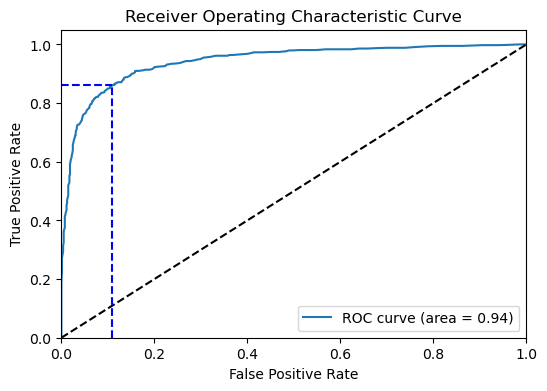

Feature Importances for RandomForestRegressor:
         Feature  Importance
4          sim_Y    0.290351
0     variations    0.254047
1        density    0.161936
3          sim_X    0.119552
2    consistency    0.102885
5  spec_charge_2    0.047921
7  spec_charge_4    0.013424
6  spec_charge_3    0.009884


Training GradientBoostingRegressor...
ROC AUC snap_label: 0.9222054763291877
Optimal threshold: 0.44489272247105593
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       814
           1       0.86      0.84      0.85       776

    accuracy                           0.86      1590
   macro avg       0.86      0.86      0.86      1590
weighted avg       0.86      0.86      0.86      1590



/tmp/ipykernel_1472807/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1472807/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


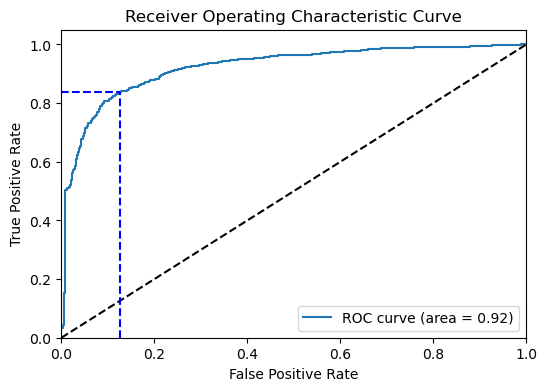

Feature Importances for GradientBoostingRegressor:
         Feature  Importance
4          sim_Y    0.298600
0     variations    0.238367
3          sim_X    0.147506
1        density    0.142391
2    consistency    0.091462
5  spec_charge_2    0.058979
7  spec_charge_4    0.013295
6  spec_charge_3    0.009401


Training GradientBoostingClassifier...
ROC AUC snap_label: 0.8774063426125281
Optimal threshold: 1.0
Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       814
           1       0.89      0.85      0.87       776

    accuracy                           0.88      1590
   macro avg       0.88      0.88      0.88      1590
weighted avg       0.88      0.88      0.88      1590



/tmp/ipykernel_1472807/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1472807/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


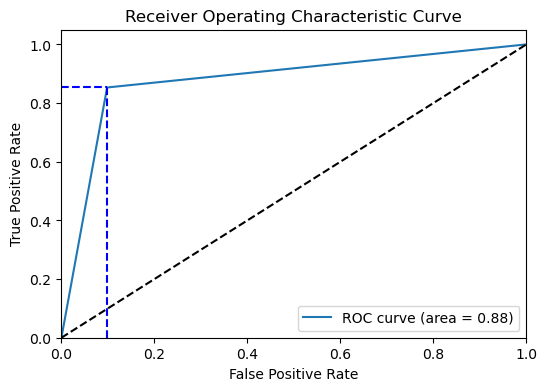

Feature Importances for GradientBoostingClassifier:
         Feature  Importance
4          sim_Y    0.291159
0     variations    0.237734
1        density    0.155201
3          sim_X    0.143699
2    consistency    0.095029
5  spec_charge_2    0.056341
7  spec_charge_4    0.013412
6  spec_charge_3    0.007424




In [12]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve

# Define the models and their associated hyperparameters
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [1, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    }
]

# Loop over the models
for m in models:
    print(f"Training {m['name']}...")

    # Apply GridSearchCV
    grid = GridSearchCV(m['model'], m['params'], cv=5, verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_proba = grid.predict(X_val)

    # Scatter plot of y_pred_proba vs snap_score_1
    # scatter_plot(y_val['snap_1'], y_pred_proba, 'snap_score_1', 'y_pred_proba', f"Plot for {m['name']}", legend=True)

    # Calculate the ROC AUC for snap_label
    roc_auc_snap_label = roc_auc_score(y_val, y_pred_proba)

    # Print the ROC AUC
    print(f"ROC AUC snap_label: {roc_auc_snap_label}")

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print(f"Optimal threshold: {optimal_threshold}")

    # Convert probabilities to binary predictions using the optimal threshold
    y_pred_snap_label = (y_pred_proba >= optimal_threshold).astype(int)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {grid.best_params_}")

    # Print the classification report for snap_label
    print(classification_report(y_val, y_pred_snap_label))

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, optimal_idx)

    # Get the feature importances
    feature_importances = grid.best_estimator_.feature_importances_

    # Create a DataFrame to display the feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print(f"Feature Importances for {m['name']}:")
    print(importance_df)
    print("\n")


3060
3060
Training RandomForestRegressor...
ROC AUC snap_label: 0.8317507409002254
Optimal threshold: 0.5131734961117315
Best hyperparameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       814
           1       0.78      0.74      0.76       776

    accuracy                           0.77      1590
   macro avg       0.77      0.77      0.77      1590
weighted avg       0.77      0.77      0.77      1590



/tmp/ipykernel_1479575/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1479575/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


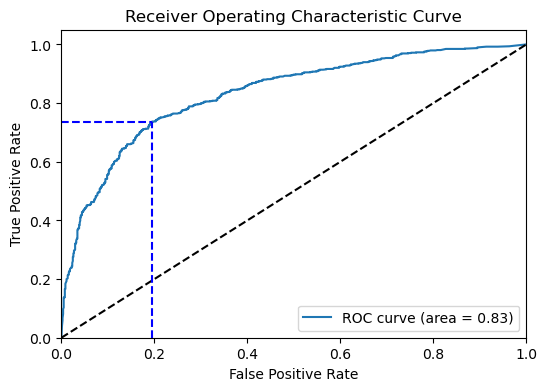

Feature Importances for RandomForestRegressor:
       Feature  Importance
0      density    0.511649
1  consistency    0.488351


Training GradientBoostingRegressor...
ROC AUC snap_label: 0.7991226348185111
Optimal threshold: 0.576095658520728
Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       814
           1       0.76      0.67      0.71       776

    accuracy                           0.74      1590
   macro avg       0.74      0.74      0.74      1590
weighted avg       0.74      0.74      0.74      1590



/tmp/ipykernel_1479575/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1479575/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


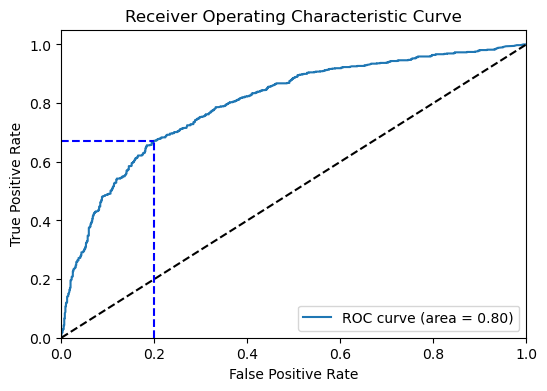

Feature Importances for GradientBoostingRegressor:
       Feature  Importance
0      density    0.513112
1  consistency    0.486888


Training GradientBoostingClassifier...
ROC AUC snap_label: 0.7402384812178627
Optimal threshold: 1.0
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       814
           1       0.73      0.74      0.74       776

    accuracy                           0.74      1590
   macro avg       0.74      0.74      0.74      1590
weighted avg       0.74      0.74      0.74      1590



/tmp/ipykernel_1479575/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1479575/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


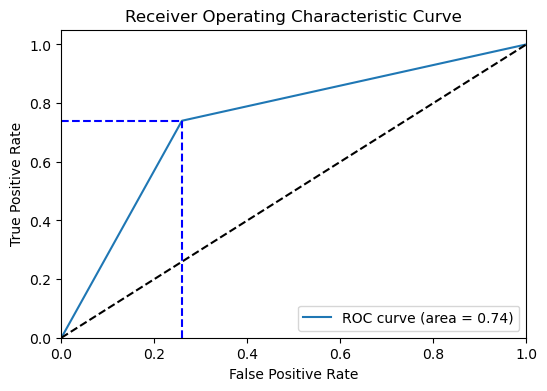

Feature Importances for GradientBoostingClassifier:
       Feature  Importance
0      density    0.506681
1  consistency    0.493319




In [8]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve

# Load the data
df_all = pd.read_csv('outputs/df_all.csv')

# Preprocess the data
df_all.drop('id', axis=1, inplace=True)
df_all = pd.get_dummies(df_all, columns=['spec_charge'])
df_all['snap_label'] = df_all['snap_label'].map({True: 1, False: 0})

# Define the feature columns
# feature_cols = [col for col in df_all.columns if col not in ['snap_1', 'snap_2', 'snap_label']]
feature_cols = ['density', 'consistency']

# Define the label columns
label_cols = ['snap_1', 'snap_2', 'snap_label']

# Separate the features and labels
X = df_all[feature_cols]
y = df_all[label_cols]

print(len(X))
print(len(y))

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
# X = scaler.fit_transform(X.values.reshape(-1, 1))

# Apply SMOTE for 'snap_label'
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y['snap_label'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Define the models and their associated hyperparameters
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [1, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    }
]

# Loop over the models
for m in models:
    print(f"Training {m['name']}...")

    # Apply GridSearchCV
    grid = GridSearchCV(m['model'], m['params'], cv=5, verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_proba = grid.predict(X_val)

    # Scatter plot of y_pred_proba vs snap_score_1
    # scatter_plot(y_val['snap_1'], y_pred_proba, 'snap_score_1', 'y_pred_proba', f"Plot for {m['name']}", legend=True)

    # Calculate the ROC AUC for snap_label
    roc_auc_snap_label = roc_auc_score(y_val, y_pred_proba)

    # Print the ROC AUC
    print(f"ROC AUC snap_label: {roc_auc_snap_label}")

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print(f"Optimal threshold: {optimal_threshold}")

    # Convert probabilities to binary predictions using the optimal threshold
    y_pred_snap_label = (y_pred_proba >= optimal_threshold).astype(int)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {grid.best_params_}")

    # Print the classification report for snap_label
    print(classification_report(y_val, y_pred_snap_label))

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, optimal_idx)

    # Get the feature importances
    feature_importances = grid.best_estimator_.feature_importances_

    # Create a DataFrame to display the feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print(f"Feature Importances for {m['name']}:")
    print(importance_df)
    print("\n")


Training RandomForestRegressor...
ROC AUC snap_label: 0.7265254945667317
Optimal threshold: 0.39333206743056714
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       814
           1       0.67      0.67      0.67       776

    accuracy                           0.68      1590
   macro avg       0.68      0.68      0.68      1590
weighted avg       0.68      0.68      0.68      1590



/tmp/ipykernel_1405844/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1405844/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


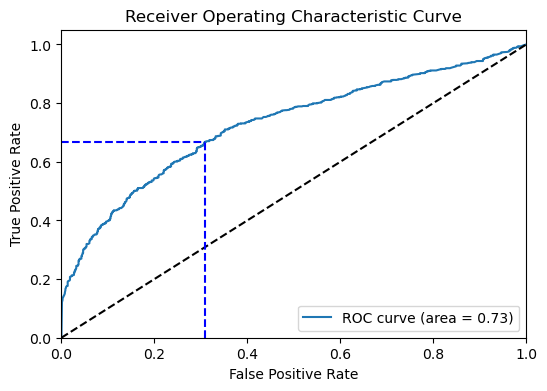

Feature Importances for RandomForestRegressor:
  Feature  Importance
0   sim_Y         1.0


Training GradientBoostingRegressor...
ROC AUC snap_label: 0.7413648711973454
Optimal threshold: 0.46411590697045807
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       814
           1       0.70      0.64      0.67       776

    accuracy                           0.69      1590
   macro avg       0.69      0.69      0.69      1590
weighted avg       0.69      0.69      0.69      1590



/tmp/ipykernel_1405844/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1405844/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


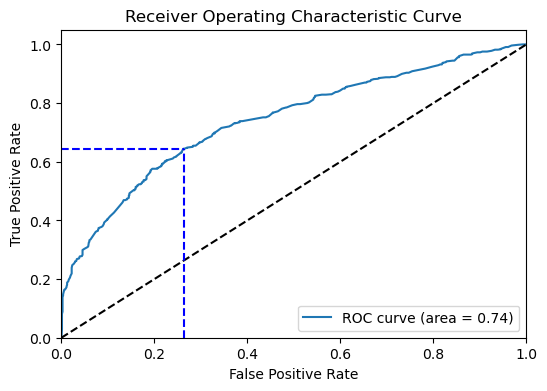

Feature Importances for GradientBoostingRegressor:
  Feature  Importance
0   sim_Y         1.0


Training GradientBoostingClassifier...
ROC AUC snap_label: 0.6721627320854124
Optimal threshold: 1.0
Best hyperparameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.66      0.76      0.70       814
           1       0.70      0.59      0.64       776

    accuracy                           0.67      1590
   macro avg       0.68      0.67      0.67      1590
weighted avg       0.68      0.67      0.67      1590



/tmp/ipykernel_1405844/547698018.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], 'k--', color='blue')
/tmp/ipykernel_1405844/547698018.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], 'k--', color='blue')


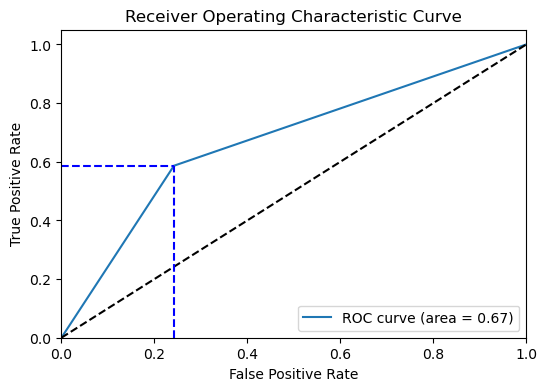

Feature Importances for GradientBoostingClassifier:
  Feature  Importance
0   sim_Y         1.0




In [7]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve

# Load the data
df_all = pd.read_csv('outputs/df_all.csv')

# Preprocess the data
df_all.drop('id', axis=1, inplace=True)
df_all = pd.get_dummies(df_all, columns=['spec_charge'])
df_all['snap_label'] = df_all['snap_label'].map({True: 1, False: 0})

# Define the feature columns
# feature_cols = [col for col in df_all.columns if col not in ['snap_1', 'snap_2', 'snap_label']]
feature_cols = ['sim_Y']

# Define the label columns
label_cols = ['snap_1', 'snap_2', 'snap_label']

# Separate the features and labels
X = df_all[feature_cols]
y = df_all[label_cols]

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X.values.reshape(-1, 1))

# Apply SMOTE for 'snap_label'
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y['snap_label'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Define the models and their associated hyperparameters
models = [
    {
        'name': 'RandomForestRegressor',
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [1, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10]
        }
    },
    {
        'name': 'GradientBoostingRegressor',
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 5, 10, 20]
        }
    }
]

# Loop over the models
for m in models:
    print(f"Training {m['name']}...")

    # Apply GridSearchCV
    grid = GridSearchCV(m['model'], m['params'], cv=5, verbose=0, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_proba = grid.predict(X_val)

    # Scatter plot of y_pred_proba vs snap_score_1
    # scatter_plot(y_val['snap_1'], y_pred_proba, 'snap_score_1', 'y_pred_proba', f"Plot for {m['name']}", legend=True)

    # Calculate the ROC AUC for snap_label
    roc_auc_snap_label = roc_auc_score(y_val, y_pred_proba)

    # Print the ROC AUC
    print(f"ROC AUC snap_label: {roc_auc_snap_label}")

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Print the optimal threshold
    print(f"Optimal threshold: {optimal_threshold}")

    # Convert probabilities to binary predictions using the optimal threshold
    y_pred_snap_label = (y_pred_proba >= optimal_threshold).astype(int)

    # Print the best hyperparameters
    print(f"Best hyperparameters: {grid.best_params_}")

    # Print the classification report for snap_label
    print(classification_report(y_val, y_pred_snap_label))

    # Plot the ROC curve
    plot_roc_curve(fpr, tpr, optimal_idx)

    # Get the feature importances
    feature_importances = grid.best_estimator_.feature_importances_

    # Create a DataFrame to display the feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print(f"Feature Importances for {m['name']}:")
    print(importance_df)
    print("\n")


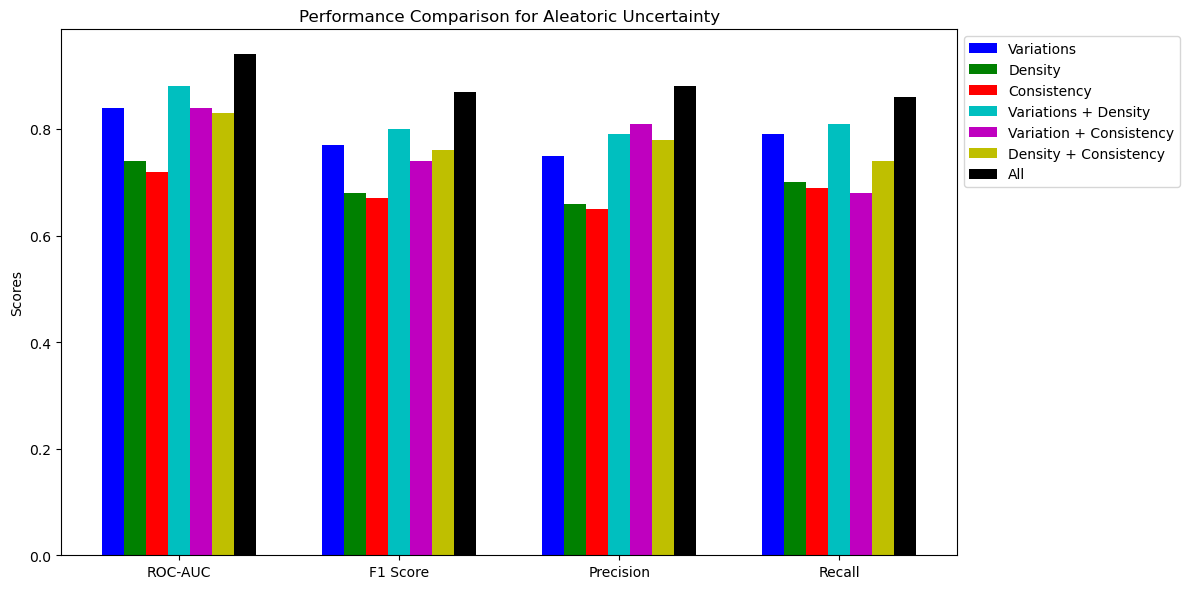

In [19]:
import numpy as np
import matplotlib.pyplot as plt

score_types = ['ROC-AUC', 'F1 Score', 'Precision', 'Recall']
metrics = ['Variations', 'Density', 'Consistency', 'Variations + Density', 'Variation + Consistency', 'Density + Consistency', 'All']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
values = {
    'ROC-AUC': [0.84, 0.74, 0.72, 0.88, 0.84, 0.83, 0.94],
    'F1 Score': [0.77, 0.68, 0.67, 0.8, 0.74, 0.76, 0.87],
    'Precision': [0.75, 0.66, 0.65, 0.79, 0.81, 0.78, 0.88],
    'Recall': [0.79, 0.7, 0.69, 0.81, 0.68, 0.74, 0.86]
}

x = np.arange(len(score_types))
width = 0.1

fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, [values[score_type][i] for score_type in score_types], width, label=metric, color=colors[i])

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison for Aleatoric Uncertainty')
ax.set_xticks(x + width * 3)
ax.set_xticklabels(score_types)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()


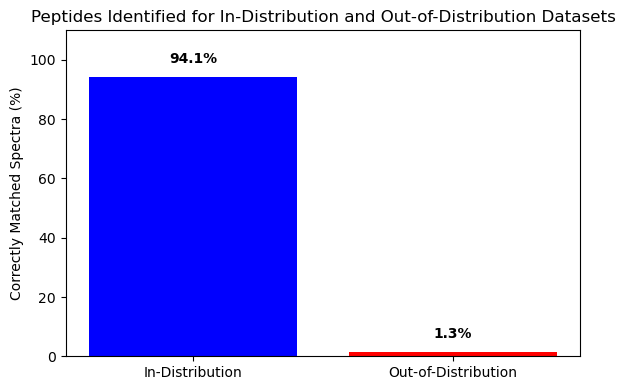

In [2]:
import matplotlib.pyplot as plt

# Data
datasets = ['In-Distribution', 'Out-of-Distribution']
percentage_coverage = [94.1, 1.3]

# Bar plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(datasets, percentage_coverage, color=['blue', 'red'])

# Adding data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, f'{yval}%', ha='center', color='black', weight='bold')

# Labeling axes
ax.set_ylabel('Correctly Matched Spectra (%)')
ax.set_title('Peptides Identified for In-Distribution and Out-of-Distribution Datasets')
plt.ylim(0, 110) # To make sure the labels fit

plt.tight_layout()
plt.show()
